# Offensive Strategies (Cont.)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

## Hypothesis 3

Running certain offensive formations can result in more missed tackles,
particularly for rushing plays.

In [86]:
df = pd.read_csv('../data/tackles.csv').groupby(['gameId', 'playId']).sum()
df = df.join(
    other = pd.read_csv('../data/plays.csv').set_index(['gameId', 'playId']),
    on = ['gameId', 'playId'],
    how = 'inner'
)
df.head()

nflId  tackle  assist  forcedFumble  pff_missedTackle  \
gameId     playId                                                          
2022090800 56      43294       1       0             0                 0   
           80      53532       1       0             0                 0   
           101     42816       1       0             0                 0   
           122     38577       1       0             0                 0   
           146     81912       0       2             0                 0   

                   ballCarrierId ballCarrierDisplayName  \
gameId     playId                                         
2022090800 56              42489           Stefon Diggs   
           80              46076             Josh Allen   
           101             47857       Devin Singletary   
           122             47857       Devin Singletary   
           146             47857       Devin Singletary   

                                                     playDescription  quarter  \
gameId     playId                                                               
2022090800 56      (15:00) (Shotgun) J.Allen pass short right to ...        1   
           80      (14:29) (No Huddle, Shotgun) J.Allen scrambles...        1   
           101     (13:54) D.Singletary right end to BUF 45 for 7...        1   
           122     (13:15) (Shotgun) J.Allen pass short right to ...        1   
           146     (12:33) (Shotgun) D.Singletary left tackle to ...        1   

                   down  ...  preSnapHomeTeamWinProbability  \
gameId     playId        ...                                  
2022090800 56         1  ...                       0.413347   
           80         2  ...                       0.413316   
           101        1  ...                       0.399819   
           122        2  ...                       0.384969   
           146        1  ...                       0.365938   

                  preSnapVisitorTeamWinProbability  \
gameId     playId                                    
2022090800 56                             0.586653   
           80                             0.586684   
           101                            0.600181   
           122                            0.615031   
           146                            0.634062   

                  homeTeamWinProbabilityAdded visitorTeamWinProbilityAdded  \
gameId     playId                                                            
2022090800 56                       -0.000031                     0.000031   
           80                       -0.013497                     0.013497   
           101                      -0.014850                     0.014850   
           122                      -0.019032                     0.019032   
           146                       0.021616                    -0.021616   

                   expectedPoints expectedPointsAdded  foulName1  foulName2  \
gameId     playId                                                             
2022090800 56            1.298699            0.004420        NaN        NaN   
           80            1.303119            0.823571        NaN        NaN   
           101           2.126690            0.562363        NaN        NaN   
           122           2.689053            0.399209        NaN        NaN   
           146           3.088262           -0.514056        NaN        NaN   

                  foulNFLId1  foulNFLId2  
gameId     playId                         
2022090800 56            NaN         NaN  
           80            NaN         NaN  
           101           NaN         NaN  
           122           NaN         NaN  
           146           NaN         NaN  

[5 rows x 38 columns]

Limits analysis to rush plays only.

In [87]:
df['play_count'] = 1
df['play_tackle_or_assist'] = df.apply(lambda x: 1 if x.tackle > 0 or x.assist > 0 else 0, axis=1)
df['play_missed_tackle'] = df.apply(lambda x: 1 if x.pff_missedTackle > 0 else 0, axis=1)
df['play_tackle_or_assist_not_missed'] = df.apply(lambda x: 1 if x.play_tackle_or_assist == 1 and x.play_missed_tackle == 0 else 0, axis=1)
df = df[['offenseFormation', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle', 'play_count', 'play_missed_tackle', 'play_tackle_or_assist_not_missed']].groupby(['offenseFormation']).sum()
df['play_tackle_or_assist_not_missed_percentage'] = df.play_tackle_or_assist_not_missed.div(df.play_count).mul(100)
df['play_missed_tackle_percentage'] = df.play_missed_tackle.div(df.play_count).mul(100)
df

,tackle,assist,forcedFumble,pff_missedTackle,play_count,play_missed_tackle,play_tackle_or_assist_not_missed,play_tackle_or_assist_not_missed_percentage,play_missed_tackle_percentage
offenseFormation,,,,,,,,,
EMPTY,732,237,10,129,818,111,707,86.430318,13.569682
I_FORM,708,508,9,142,897,127,770,85.841695,14.158305
JUMBO,69,48,0,14,92,12,80,86.956522,13.043478
PISTOL,480,265,2,102,577,86,491,85.095321,14.904679
SHOTGUN,5164,2497,57,1058,6134,906,5228,85.229866,14.770134
SINGLEBACK,2697,1891,21,631,3422,524,2898,84.687317,15.312683
WILDCAT,65,48,0,14,81,11,70,86.419753,13.580247


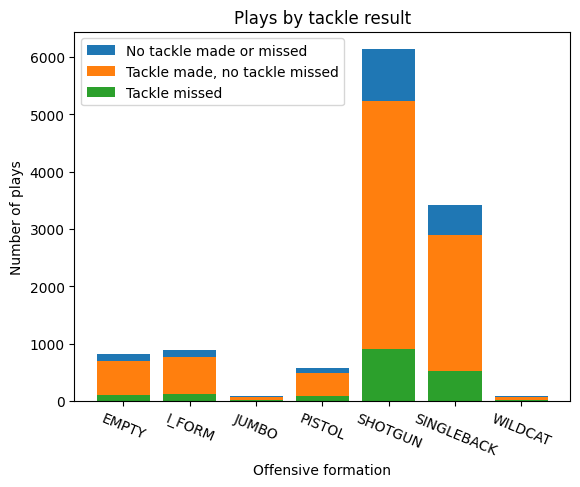

In [90]:
fig, ax = plt.subplots()
ax.set_title('Plays by tackle result')
ax.set_xlabel('Offensive formation')
ax.set_ylabel('Number of plays')
ax.bar(df.index, df.play_count.values, label='No tackle made or missed')
ax.bar(df.index, df.play_tackle_or_assist_not_missed.values, label='Tackle made, no tackle missed')
ax.bar(df.index, df.play_missed_tackle.values, label='Tackle missed')
ax.legend()
for tick in ax.get_xticklabels():
    tick.set_rotation(-22.5)
plt.show()

In [89]:
chi2_contingency(df[['play_missed_tackle', 'play_tackle_or_assist_not_missed']])

Chi2ContingencyResult(statistic=np.float64(2.3175410448629528), pvalue=np.float64(0.8883028511267856), dof=6, expected_freq=array([[ 120.92055569,  697.07944431],
       [ 132.59870227,  764.40129773],
       [  13.5998669 ,   78.4001331 ],
       [  85.2948174 ,  491.7051826 ],
       [ 906.75634307, 5227.24365693],
       [ 505.85591881, 2916.14408119],
       [  11.97379586,   69.02620414]]))

In conclusion, the evidence is insufficent to support the third offensive strategy hypothesis. However, offences show a clear preference for the shotgun and singleback formations.